# Credit Fraud Detection Based on Anomaly Detection

# 1. Libraries

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# 2. Look at the data

### Load data

Source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [291]:
df = pd.read_csv('datasets/creditcard.csv')

### Look

In [292]:
print(f'Размер: {df.shape}')

Размер: (284807, 31)


In [293]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Transform data

In [294]:
Y_pd = df['Class']

### Check the deviations on the histagrams

In [295]:
X_0 = df['V1'][Y_pd == 0]
X_1 = df['V1'][Y_pd == 1]

Look at the *V1* histogram

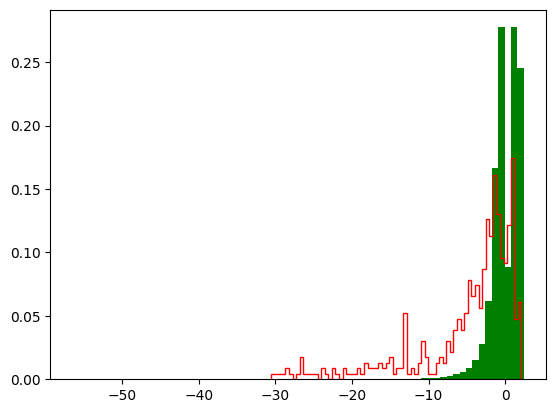

In [296]:
plt.hist(X_0, density=True, bins=70, color='green')
plt.hist(X_1, density=True, bins=70, color='red', histtype='step')
plt.show()

Plot for every feature

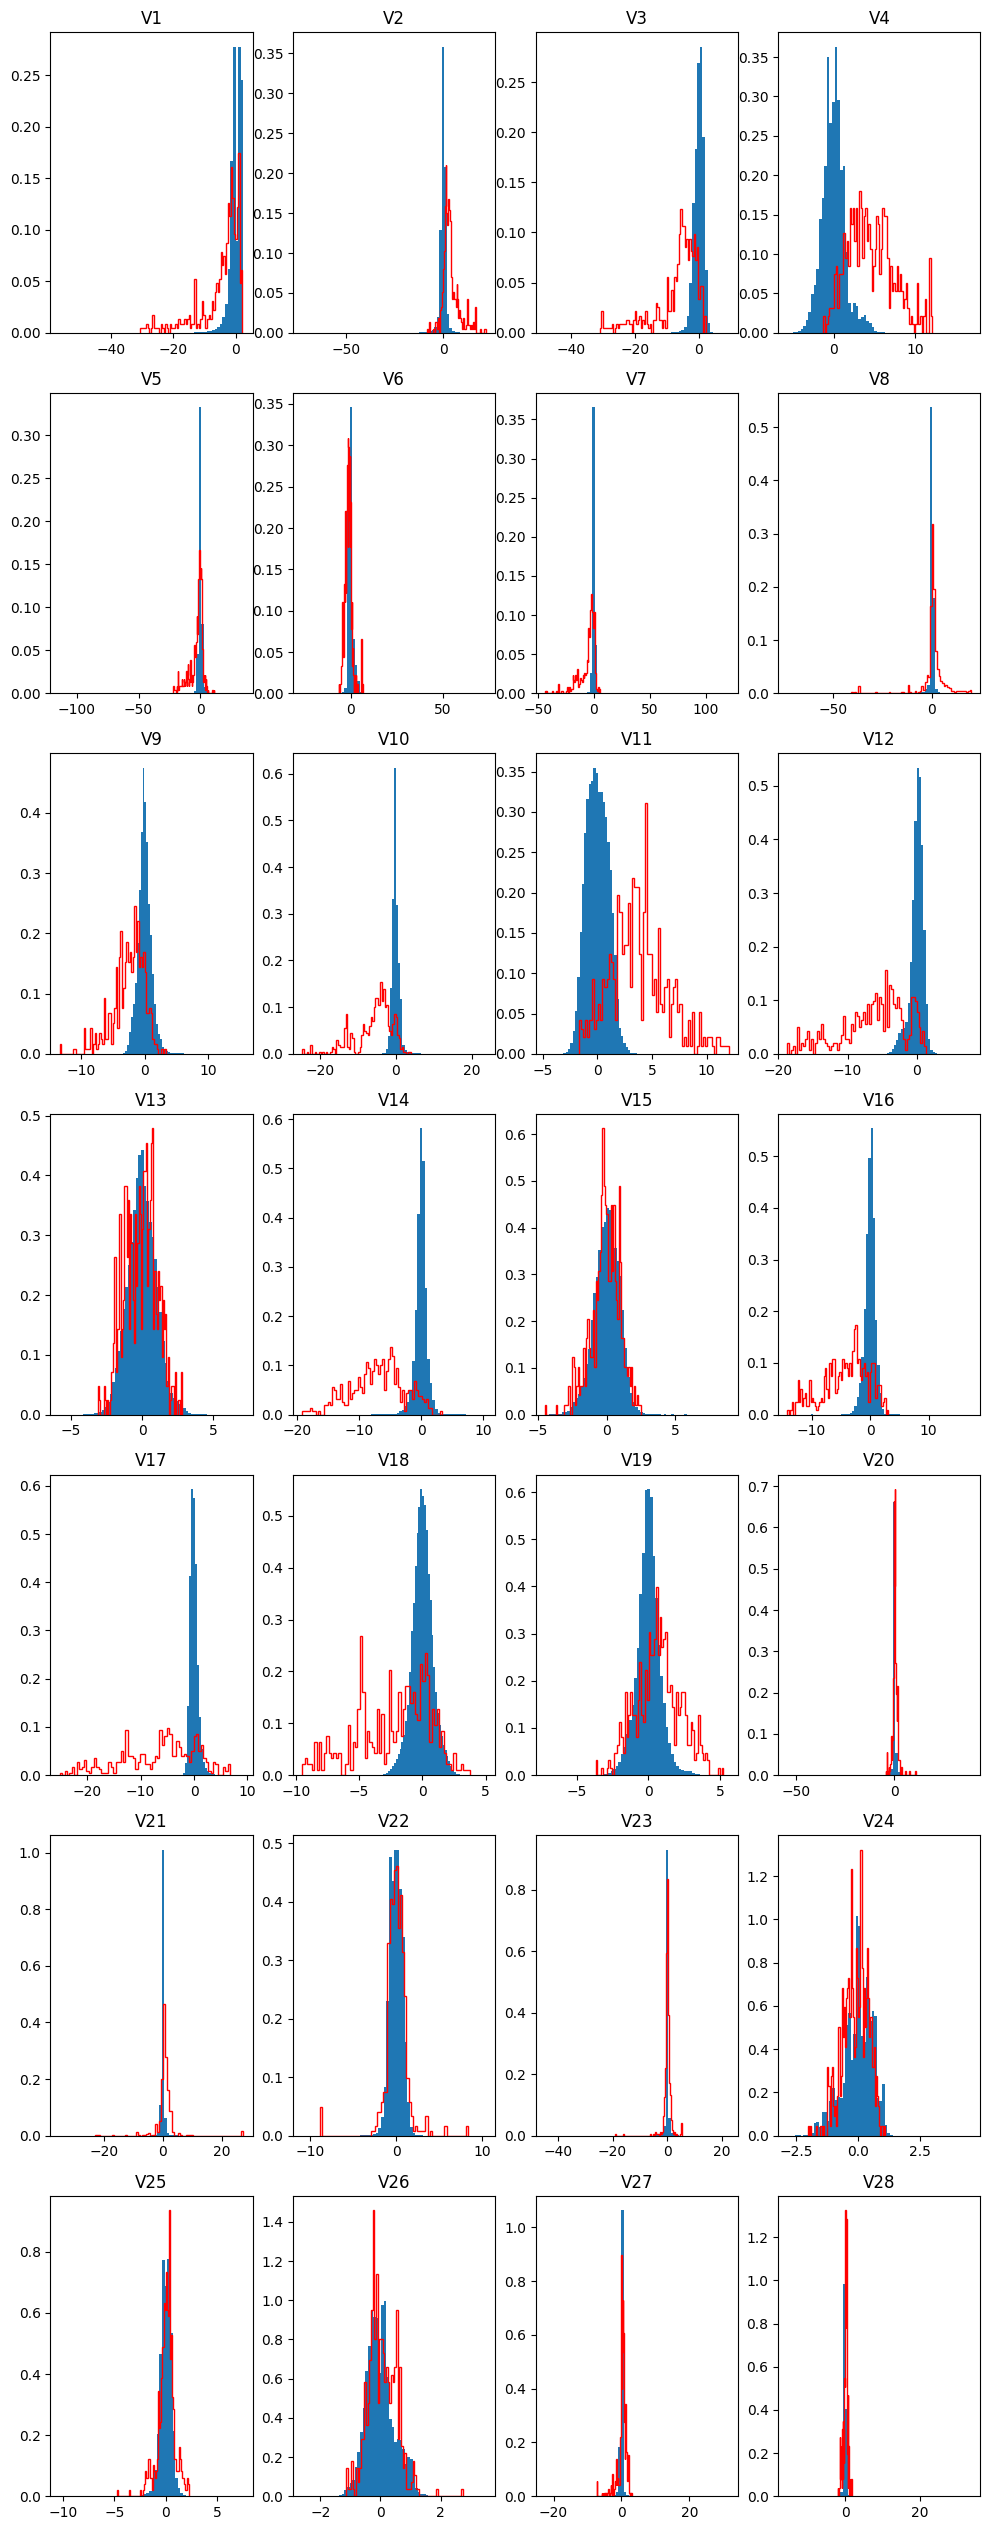

In [297]:
fig, axs = plt.subplots(7, 4, figsize=(12, 8*4))
features = df.columns[1:29]
for i in range(len(features)):
    X_0 = df[features[i]][Y_pd == 0]
    X_1 = df[features[i]][Y_pd == 1]
    
    ax = axs[i // 4, i % 4]
    ax.hist(X_0, density=True, bins=70)
    ax.hist(X_1, density=True, bins=70, color='red', histtype='step')
    ax.set_title(features[i])

Let's pick the most usefull ones:
- V3
- V4
- V11
- V12
- V14
- V16
- V17
- V18

# 3. Data preparation

Firstly, let's pick only usefull features and y's.

In [184]:
X = np.array(df.iloc[:,[3, 4, 11, 12, 14, 16, 17, 18]])
Y = np.array(df.iloc[:,[30]])

To-do: transform features to fit bell

To get Mu and sigma we need to separate negative and positive samples.

In [185]:
x_0 = X[Y.flatten() == 0]
x_1 = X[Y.flatten() == 1]

We will use three separate sets:
- Training: 60% negative
- CV: 20% negative 50% positive
- Test: 20% negative 50% positive

In [223]:
x_train, x_0_cv = train_test_split(x_0, train_size=0.6, random_state=1)
x_0_cv, x_0_test = train_test_split(x_0_cv, train_size=0.5, random_state=1)

x_1_cv, x_1_test = train_test_split(x_1, train_size=0.5)

In [228]:
print(f'Training: {len(x_train)} neg')
print(f'CV: {len(x_0_cv)} neg, {len(x_1_cv)} pos')
print(f'Test: {len(x_0_test)} neg, {len(x_1_test)} pos')

Training: 170589 neg
CV: 56863 neg, 246 pos
Test: 56863 neg, 246 pos


# 4. P() function

Mean and sigma

In [263]:
m, n = x_train.shape

means = sum(x_train) / m

sigmas_sq = np.zeros(n)
for i in range(m):
    sigmas_sq += (x_train[i] - means)**2
sigmas_sq /= m

Create p(x) function

In [264]:
def p(x, mean, sigma_sq):
    return np.exp(-1 * (x - mean)**2 / (2 * sigma_sq)) / (np.sqrt(2 * np.pi) * np.sqrt(sigma_sq))

In [267]:
p(0, means[0], sigmas_sq[0])

0.27259933259557817

Show normal deviation

In [278]:
canvas = np.linspace(-10, 10, 100)

In [279]:
p(canvas, means[0], sigmas_sq[0])

array([1.90266997e-11, 4.84429055e-11, 1.21009915e-10, 2.96575845e-10,
       7.13139762e-10, 1.68243223e-09, 3.89425653e-09, 8.84373228e-09,
       1.97047382e-08, 4.30754480e-08, 9.23874518e-08, 1.94410728e-07,
       4.01376107e-07, 8.13030536e-07, 1.61579496e-06, 3.15057408e-06,
       6.02722206e-06, 1.13127644e-05, 2.08326415e-05, 3.76395128e-05,
       6.67217913e-05, 1.16042066e-04, 1.98010063e-04, 3.31499686e-04,
       5.44506455e-04, 8.77499738e-04, 1.38744255e-03, 2.15232117e-03,
       3.27584388e-03, 4.89174001e-03, 7.16683803e-03, 1.03018652e-02,
       1.45287480e-02, 2.01031711e-02, 2.72913487e-02, 3.63504239e-02,
       4.75026691e-02, 6.09046705e-02, 7.66138409e-02, 9.45557458e-02,
       1.14496620e-01, 1.36025853e-01, 1.58552941e-01, 1.81322291e-01,
       2.03447401e-01, 2.23963449e-01, 2.41894614e-01, 2.56329920e-01,
       2.66499536e-01, 2.71842694e-01, 2.72058892e-01, 2.67135887e-01,
       2.57350845e-01, 2.43244491e-01, 2.25571631e-01, 2.05234325e-01,
      

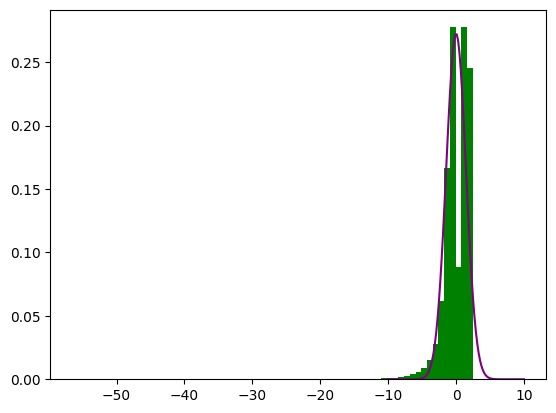

In [300]:
plt.hist(df[features[0]][Y_pd == 0], density=True, bins=70, color='green')
plt.plot(canvas, p(canvas, means[0], sigmas_sq[0]), color='purple')
plt.show()

Show deviation on top of the histograms

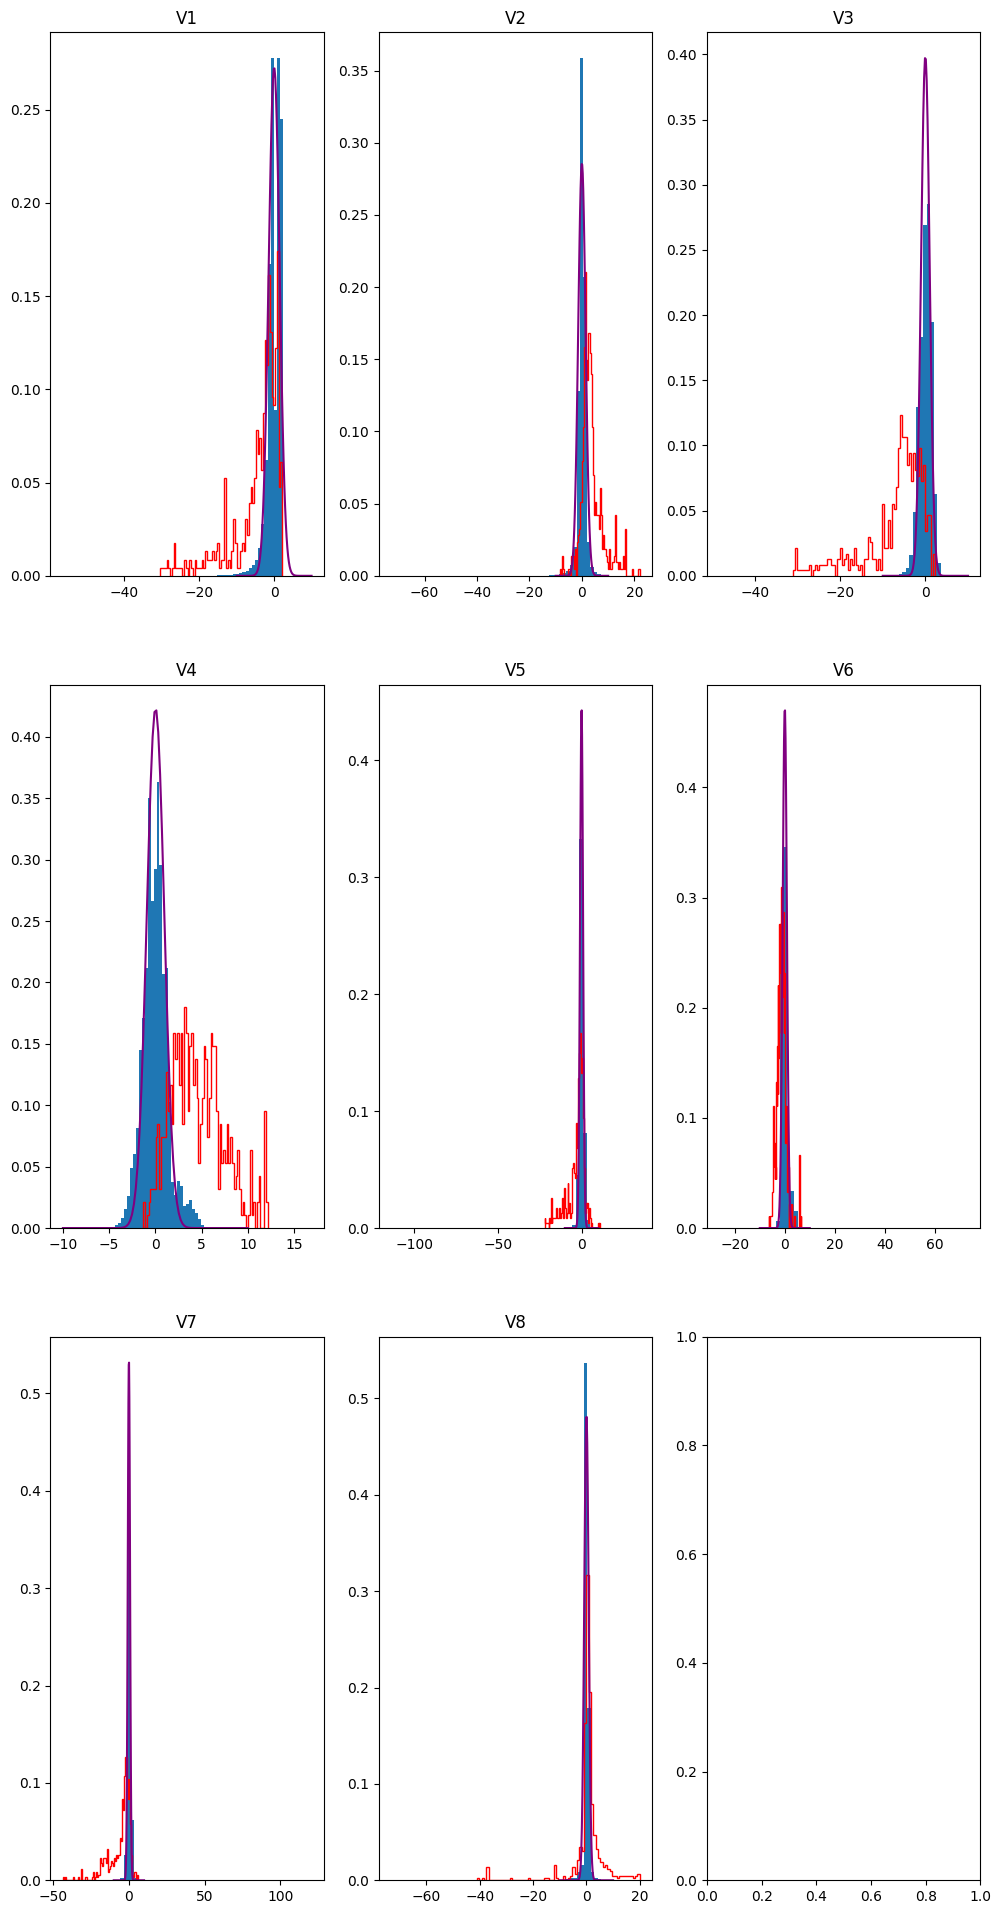

In [303]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8*3))
chosen_features = ['V3', 'V4', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']
for i in range(len(chosen_features)):
    X_0 = df[features[i]][Y_pd == 0]
    X_1 = df[features[i]][Y_pd == 1]
    
    ax = axs[i // 3, i % 3]
    ax.hist(X_0, density=True, bins=70)
    ax.hist(X_1, density=True, bins=70, color='red', histtype='step')

    canvas = np.linspace(-10, 10, 100)
    ax.plot(canvas, p(canvas, means[i], sigmas_sq[i]), color='purple')
    ax.set_title(features[i])

Create general P(X) function

In [331]:
def p_cum(x, means, sigmas_sq):
    p_res = 1
    n = x.shape[0]
    
    for j in range(n):
        p_res *= p(x[j], means[j], sigmas_sq[j])

    return p_res

In [340]:
p_cum(np.array([0, 0, -3, 0, 0, 0, 0, 0]), means, sigmas_sq)

8.245765785038236e-06

# 5. Find epsilon using F1 score

In [385]:
epsilon = 1e-5
epsilon_hist = []
recall_hist = []
precision_hist = []
f1_hist = []
tpr_hist = []
fpr_hist = []

for i in range(50):
    
    true_pos = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0
    
    for cv_x in x_1_cv:
        p_res = p_cum(cv_x, means, sigmas_sq)
        if p_res < epsilon:
            true_pos += 1
        else:
            false_negative += 1
    
    for cv_x in x_0_cv:
        p_res = p_cum(cv_x, means, sigmas_sq)
        if p_res < epsilon:
            false_positive += 1
        else:
            true_negative += 1

    precision = true_pos / (true_pos + false_positive)
    recall = true_pos / (true_pos + false_negative)
    f1_score = 2 * precision * recall / (precision + recall)
    tpr = true_pos / (true_pos + false_negative)
    fpr = false_positive / (false_positive + true_negative)
    
    print(f'Epsilon = {epsilon}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F1-score: {f1_score}')

    epsilon_hist.append(epsilon)
    f1_hist.append(f1_score)
    recall_hist.append(recall)
    precision_hist.append(precision)
    tpr_hist.append(tpr)
    fpr_hist.append(fpr)

    epsilon /= 10

Epsilon = 1e-05
Recall: 0.943089430894309
Precision: 0.013682472281198396
F1-score: 0.026973607720032555
Epsilon = 1.0000000000000002e-06
Recall: 0.9024390243902439
Precision: 0.0280763880106235
F1-score: 0.05445848154053723
Epsilon = 1.0000000000000002e-07
Recall: 0.8943089430894309
Precision: 0.05593694380879736
F1-score: 0.10528834649437664
Epsilon = 1.0000000000000002e-08
Recall: 0.8658536585365854
Precision: 0.09638009049773756
F1-score: 0.17345276872964172
Epsilon = 1.0000000000000003e-09
Recall: 0.8577235772357723
Precision: 0.14932767162066526
F1-score: 0.2543701024713683
Epsilon = 1.0000000000000003e-10
Recall: 0.8495934959349594
Precision: 0.18811881188118812
F1-score: 0.30803242446573326
Epsilon = 1.0000000000000003e-11
Recall: 0.8414634146341463
Precision: 0.23603192702394526
F1-score: 0.36865538735529835
Epsilon = 1.0000000000000002e-12
Recall: 0.8373983739837398
Precision: 0.2959770114942529
F1-score: 0.43736730360934184
Epsilon = 1.0000000000000002e-13
Recall: 0.82926829

### F1 score plot

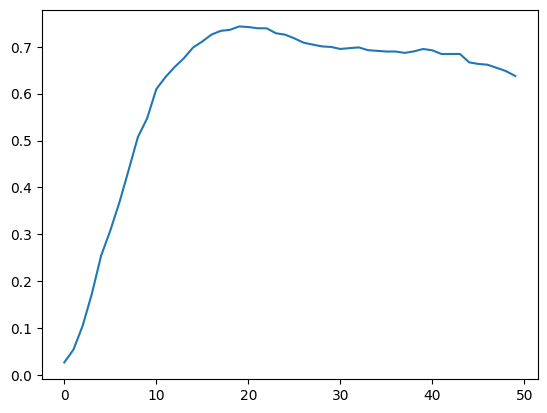

In [381]:
plt.plot(f1_hist)
plt.show()

In [384]:
print(f'Best epsilon is: {epsilon_hist[f1_hist.index(max(f1_hist))]}')
print(f'F1-score: {max(f1_hist)}')

Best epsilon is: 1.0000000000000001e-24
F1-score: 0.7431906614785991


### Recall plot

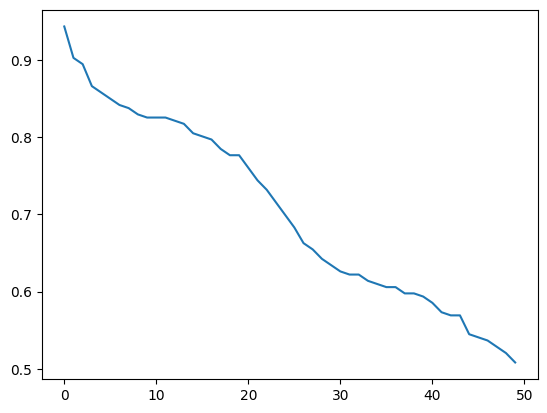

In [382]:
plt.plot(recall_hist)
plt.show()

### Precision plot

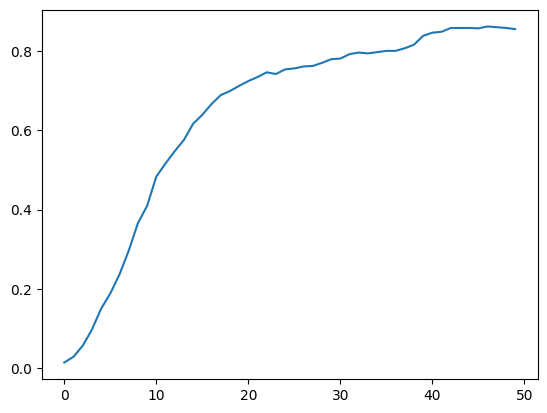

In [383]:
plt.plot(precision_hist)
plt.show()

### AUC ROC Curve

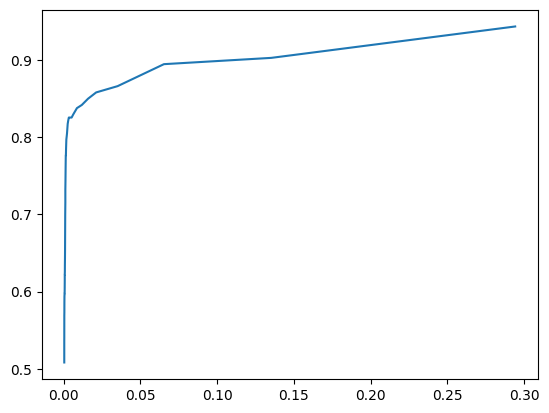

In [386]:
plt.plot(fpr_hist, tpr_hist)
plt.show()